# Week 4 — Academic Success Predictor (EDM)

You are the teaching team's **lead data scientists**. Using a (synthetic) pre-course survey dataset, you will:

- explore the cohort’s baseline readiness
- engineer meaningful features
- build a predictive model using **PyTorch `nn.Linear`** (regression or classification)
- design a simple **At‑Risk Intervention** alert

**Important**
- This dataset (`student_success_survey.csv`) is **synthetic** and created for learning.
- Do **not** use `student_uid` as a predictive feature (it is an identifier).

---

## Learning goals
- Practice real-world preprocessing: missing values, encoding, scaling
- Build a clean ML pipeline and avoid leakage
- Compare regression vs classification framing
- Interpret linear model weights and discuss limitations
- Translate predictions into actionable interventions (ethics-aware)


## 0) Setup & reproducibility

Run this cell first. If you are using **Google Colab**, you usually already have `pandas`, `sklearn`, and `torch` installed.


### Run the below cell if you are running locally!

Create your virtual environment before continuing (or not up to you)

In [23]:
import os 
# WORKING_DIRECTORY = '<YOUR_WORKING_DIRECTORY>'       # uncomment both lines if you are running locally
# os.chdir(WORKING_DIRECTORY)
os.getcwd()


'/Users/vancence/Desktop/50.038-Computational-Data-Science/lab4'

In [24]:
%pip install -r requirements.txt 

Note: you may need to restart the kernel to use updated packages.


In [25]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)


Using device: cpu


## 1) Load the dataset

Place `student_success_survey.csv` in the same folder as this notebook.

**Colab tip**: upload the CSV from your computer.


In [26]:
# If you're in Colab, uncomment this:
# from google.colab import files
# files.upload()  # select student_success_survey.csv

DATA_PATH = "student_success_survey.csv"  # adjust if needed

df = pd.read_csv(DATA_PATH)
print(df.shape)
df.head()


(240, 25)


,student_uid,pillar,current_term,cgpa,prereq_ct_grade,used_pytorch_tensorflow,used_big_data_tools,diag_python_mod_answer,diag_pvalue_answer,diag_pca_answer,...,grit_i_finish_what_i_begin,cse_debug_python_without_help,cse_learn_new_ml_library,cse_explain_model_theory,cse_interpret_complex_viz,hours_per_week_planned,commute_minutes_daily,team_formed_for_final_project,laptop_or_cloud_ready,final_course_score
0,STU_001,ASD,Term 7,4.62,A/A+,Yes,No,Error,Statistically significant (reject H0),Finding eigenvalues and eigenvectors,...,4,3,5,3,3,7.0,21.0,Yes,Yes,83.0
1,STU_002,ASD,Term 6,4.00,A-,No,Yes,2,Statistically significant (reject H0),Integration by parts,...,3,4,3,3,4,6.0,63.0,No,Yes,65.9
2,STU_003,ASD,Term 6,4.13,B+,No,No,2,Statistically significant (reject H0),Finding eigenvalues and eigenvectors,...,1,5,4,4,5,8.0,60.0,Yes,Yes,80.3
3,STU_004,ISTD,Term 6,4.69,A/A+,Yes,No,2,Statistically significant (reject H0),Finding eigenvalues and eigenvectors,...,3,3,4,3,2,3.0,31.0,Yes,Yes,71.1
4,STU_005,ISTD,Term 7,4.63,A/A+,Yes,No,0.66,96% probability H0 is true,Finding eigenvalues and eigenvectors,...,2,4,4,4,5,7.0,15.0,Yes,Yes,68.2


### Quick sanity checks

✅ You should see ~200+ rows and ~20–30 columns.


In [27]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 25 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   student_uid                          240 non-null    str    
 1   pillar                               240 non-null    str    
 2   current_term                         240 non-null    str    
 3   cgpa                                 231 non-null    float64
 4   prereq_ct_grade                      240 non-null    str    
 5   used_pytorch_tensorflow              240 non-null    str    
 6   used_big_data_tools                  240 non-null    str    
 7   diag_python_mod_answer               240 non-null    str    
 8   diag_pvalue_answer                   240 non-null    str    
 9   diag_pca_answer                      240 non-null    str    
 10  grit_distracted_by_new_ideas         240 non-null    int64  
 11  grit_setbacks_dont_discourage_me     240 no

In [28]:
# Missing values per column
(df.isna().mean().sort_values(ascending=False) * 100).round(1).head(10)


commute_minutes_daily            6.2
cgpa                             3.8
hours_per_week_planned           3.3
student_uid                      0.0
grit_i_am_a_hard_worker          0.0
laptop_or_cloud_ready            0.0
team_formed_for_final_project    0.0
cse_interpret_complex_viz        0.0
cse_explain_model_theory         0.0
cse_learn_new_ml_library         0.0
dtype: float64

## 2) Understand the features (data dictionary)

The dataset is derived from the course survey form. Key groups:

- **Academic background**: `pillar`, `current_term`, `cgpa`, `prereq_ct_grade`
- **Experience**: `used_pytorch_tensorflow`, `used_big_data_tools`
- **Diagnostic** (multiple-choice): `diag_*_answer`
- **Grit (Likert 1–5)**: `grit_*`
- **Self‑efficacy (Likert 1–5)**: `cse_*`
- **Logistics**: `hours_per_week_planned`, `commute_minutes_daily`, `team_*`, `laptop_*`

**Target variable**
- `final_course_score` (0–100): a synthetic proxy for final performance.

---

### Your first decision (Task 1): Regression or Classification?
Pick one:

- **A. Regression**: predict `final_course_score` directly.
- **B. Classification**: predict a binary label (e.g. **Distinction** vs **Non‑Distinction**).

You will implement the model as **one linear layer** using PyTorch: `nn.Linear`.


**Regression** by predicting `final_course_score` directly would be much more appropriate in this context. Utilising regression in this case is much easier than classification as there would not be extra design choice needed to be done as we would be able to use `final_course_score` as it is as compared to if we utilised classification. If we utilise classification, we would need to choose a threshold such as determining what `final_course_score` would be deemed as "Distinction" and justify it. Additionally, by using PyTorch: `nn.Linear`, both methods have similar pipelines therefore picking regression would be preferred. Also, there would be no class imbalance as compared to utilising classification, a threshold of 80 or 85 can make "Distinction" a minority class, we would then need stratification and care with metrics whereas regression in this context avoids that. By utilising regression, we also use full target information since the target is continuous (0 - 100), if we used classification, binning into "Distinction" or "Non-Disctinction" discards how far above or below the threshold a students is. Lastly, it matches with one of the EDA questions: "Is CGPA roughly linear related to `final_course_score`?", we would be able to utilise a linear regression model which fits that kind of linear relationship directly and view its results. 

## 3) Feature engineering (scaffold)

Create at least **two engineered features**.

Suggested ideas:
1. **Grit score**: average the grit items **with reverse‑coding where appropriate**.
2. **Technical readiness**: combine diagnostic correctness + experience.
3. **Time budget score**: e.g., `hours_per_week_planned - commute_minutes_daily/60`.

⚠️ Reverse-coded grit items in this dataset:
- `grit_distracted_by_new_ideas`
- `grit_short_term_obsession_then_loss`
- `grit_i_change_goals`

Reverse-coding rule for a 1–5 scale: `reversed = 6 - original`.


In [29]:
# TODO: Engineer at least TWO features.

GRIT_POS = [
    "grit_setbacks_dont_discourage_me",
    "grit_i_am_a_hard_worker",
    "grit_i_finish_what_i_begin",
]

GRIT_NEG = [
    "grit_distracted_by_new_ideas",
    "grit_short_term_obsession_then_loss",
    "grit_i_change_goals",
]

# Reverse-code the negative items
for col in GRIT_NEG:
    df[col + "_rev"] = 6 - df[col]

# Example engineered feature 1: average grit
df["avg_grit"] = df[GRIT_POS + [c + "_rev" for c in GRIT_NEG]].mean(axis=1)

# TODO: engineered feature 2 (pick one idea above)

# Correct answers 
CORRECT_PYTHON_MOD = "2"    # 2 % 3 = 2
CORRECT_PVALUE = "Statistically significant (reject H0)"
CORRECT_PCA = "Finding eigenvalues and eigenvectors"

# Compare each diagnostic to correct answer (1 if correct, 0 otherwise)
df["diag_python_mod_correct"] = (df["diag_python_mod_answer"].astype(str).str.strip() == CORRECT_PYTHON_MOD).astype(int)
df["diag_pvalue_correct"] = (df["diag_pvalue_answer"].astype(str).str.strip() == CORRECT_PVALUE).astype(int)
df["diag_pca_correct"] = (df["diag_pca_answer"].astype(str).str.strip() == CORRECT_PCA).astype(int)

# Sum across all three diagnostics -> 0, 1, 2, 3
df["diag_correctness"] = df[["diag_python_mod_correct", "diag_pvalue_correct", "diag_pca_correct"]].sum(axis=1)

# Sum across all two experiences
df["experience"] = (df["used_pytorch_tensorflow"] == "Yes").astype(int) + (df["used_big_data_tools"] == "Yes").astype(int)

# Sum diag_correctness and experience (out of 5)
df["tech_readiness"] = df["diag_correctness"] + df["experience"]

# Time budget score
df["time_budget_score"] = df["hours_per_week_planned"] - (df["commute_minutes_daily"] / 60)

# Quick check
df[["avg_grit"]].describe().T


,count,mean,std,min,25%,50%,75%,max
avg_grit,240.0,2.970833,0.822217,1.0,2.333333,3.0,3.5,5.0


In [30]:
df.head(5)

,student_uid,pillar,current_term,cgpa,prereq_ct_grade,used_pytorch_tensorflow,used_big_data_tools,diag_python_mod_answer,diag_pvalue_answer,diag_pca_answer,...,grit_short_term_obsession_then_loss_rev,grit_i_change_goals_rev,avg_grit,diag_python_mod_correct,diag_pvalue_correct,diag_pca_correct,diag_correctness,experience,tech_readiness,time_budget_score
0,STU_001,ASD,Term 7,4.62,A/A+,Yes,No,Error,Statistically significant (reject H0),Finding eigenvalues and eigenvectors,...,4,3,3.500000,0,1,1,2,1,3,6.650000
1,STU_002,ASD,Term 6,4.00,A-,No,Yes,2,Statistically significant (reject H0),Integration by parts,...,2,3,2.666667,1,1,0,2,1,3,4.950000
2,STU_003,ASD,Term 6,4.13,B+,No,No,2,Statistically significant (reject H0),Finding eigenvalues and eigenvectors,...,4,2,2.666667,1,1,1,3,0,3,7.000000
3,STU_004,ISTD,Term 6,4.69,A/A+,Yes,No,2,Statistically significant (reject H0),Finding eigenvalues and eigenvectors,...,2,1,2.000000,1,1,1,3,1,4,2.483333
4,STU_005,ISTD,Term 7,4.63,A/A+,Yes,No,0.66,96% probability H0 is true,Finding eigenvalues and eigenvectors,...,2,4,3.166667,0,0,1,1,1,2,6.750000


## 4) Exploratory Data Analysis (EDA)

Answer these questions with visuals + 2–4 sentences each:

1. Does **grit** correlate with **planned hours per week**?
2. Is **CGPA** roughly linearly related to **final_course_score**?
3. Are there obvious group differences by `pillar`?

Tip: keep plots readable; label axes; include titles.


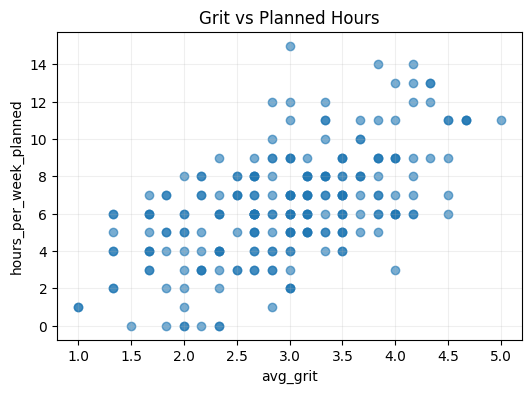

In [31]:
# 4.1 Grit vs hours
plt.figure(figsize=(6, 4))
plt.scatter(df["avg_grit"], df["hours_per_week_planned"], alpha=0.6)
plt.xlabel("avg_grit")
plt.ylabel("hours_per_week_planned")
plt.title("Grit vs Planned Hours")
plt.grid(True, alpha=0.2)
plt.show()


As seen from the graph above, there is a positive, roughly linear tendency as when average grit increases, planned hours per week also tends to increase. However, I would not call it a strong linear correlation as the data points form a wide, upward-sloping cloud with high separation. For an average grit level of 3.0, planned hours vary between 2 to around 15, the spread means the relationship is noisy and not tightly linear. Therefore, we can conclude that both attributes do correlate as average grit tends to go with higher planned hours per week, so the correlation is positive but only moderately not strongly. 

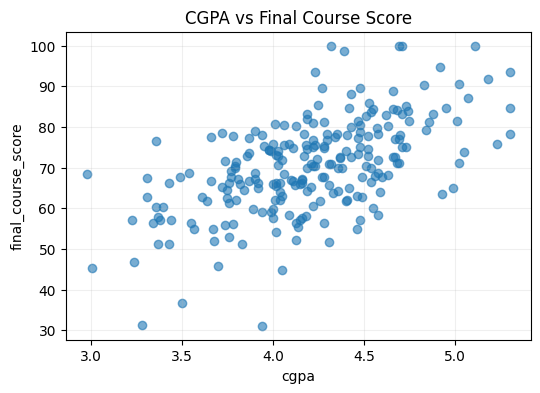

In [32]:
# 4.2 CGPA vs final score
plt.figure(figsize=(6, 4))
plt.scatter(df["cgpa"], df["final_course_score"], alpha=0.6)
plt.xlabel("cgpa")
plt.ylabel("final_course_score")
plt.title("CGPA vs Final Course Score")
plt.grid(True, alpha=0.2)
plt.show()


From the graph above, we can tell that CGPA is roughly linearly related to `final_course_score`, there is clear upward trend from the points, as higher CGPA tends to go with higher final course scores. The points follow a positive slope if we were to draw a line through the middle of the points it would have an obvious positive slope. There is a noticable scatter at around CGPA ~4.0, scores spread from around 30 to 80, so the relationship is moderate not very tight but overall there is a moderate positive linear relationship as seen from the graph above.

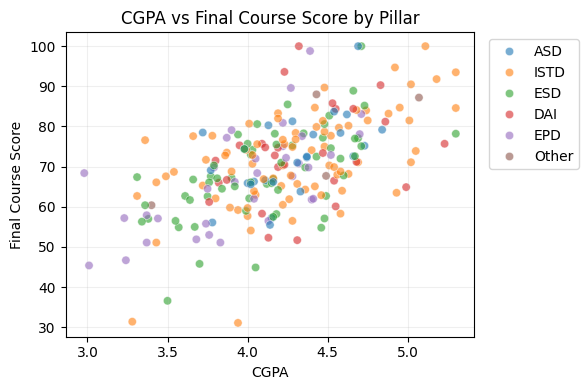

In [33]:
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.scatterplot(data=df, x="cgpa", y="final_course_score", hue="pillar", alpha=0.6)
plt.xlabel("CGPA")
plt.ylabel("Final Course Score")
plt.title("CGPA vs Final Course Score by Pillar")
plt.grid(True, alpha=0.2)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()


As seen in the graph, ISTD students relatively have higher final course scores with most of the data points being clouded between ~70 for final course score and CGPA > 4.0, whereas ESD students are generally relatively spreaded. As for the rest of the pillars the amount of data points are far too little to provide any significant generalisation and conclusion. 

## 5) Preprocessing (no leakage)

We will:
- split into train/test
- impute missing values
- standardize numeric features
- one-hot encode categorical features

✅ This produces a single numeric design matrix that you can feed into `nn.Linear`.


In [34]:
TARGET = "final_course_score"

# Define your feature set (edit this!)
NUMERIC_FEATURES = [
    "cgpa",
    "hours_per_week_planned",
    "commute_minutes_daily",
    "avg_grit",
    # TODO: add your engineered features here
    "time_budget_score",
    "tech_readiness",
]

CATEGORICAL_FEATURES = [
    "pillar",
    "current_term",
    "prereq_ct_grade",
    "used_pytorch_tensorflow",
    "used_big_data_tools",
    "diag_python_mod_answer",
    "diag_pvalue_answer",
    "diag_pca_answer",
    "team_formed_for_final_project",
    "laptop_or_cloud_ready",
]

feature_cols = NUMERIC_FEATURES + CATEGORICAL_FEATURES

X = df[feature_cols].copy()
y = df[TARGET].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

numeric_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

# scikit-learn changed this arg name; support both.
try:
    onehot = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    onehot = OneHotEncoder(handle_unknown="ignore", sparse=False)

categorical_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", onehot),
    ]
)

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, NUMERIC_FEATURES),
        ("cat", categorical_pipe, CATEGORICAL_FEATURES),
    ],
    remainder="drop",
)

X_train_np = preprocess.fit_transform(X_train)
X_test_np = preprocess.transform(X_test)

print("X_train shape:", X_train_np.shape)
print("X_test shape:", X_test_np.shape)


X_train shape: (192, 43)
X_test shape: (48, 43)


## 6) Modeling with PyTorch `nn.Linear`

You will implement a **single-layer linear model**.

### Option A — Regression (MSE)
- loss: `nn.MSELoss()`
- metrics: MSE, R²

### Option B — Classification (BCEWithLogits)
- create a binary target label (e.g. distinction = score ≥ threshold)
- loss: `nn.BCEWithLogitsLoss()`
- metrics: confusion matrix, precision, recall, F1

---

### Starter: model + training loop (works for regression)


In [35]:
class StudentSuccessLinear(nn.Module):
    def __init__(self, input_dim: int):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear(x)


def make_loaders(X_train_np, y_train_np, X_test_np, y_test_np, batch_size=32):
    X_train_t = torch.tensor(X_train_np, dtype=torch.float32)
    y_train_t = torch.tensor(y_train_np, dtype=torch.float32).view(-1, 1)
    X_test_t = torch.tensor(X_test_np, dtype=torch.float32)
    y_test_t = torch.tensor(y_test_np, dtype=torch.float32).view(-1, 1)

    train_loader = DataLoader(
        TensorDataset(X_train_t, y_train_t), batch_size=batch_size, shuffle=True
    )
    test_loader = DataLoader(
        TensorDataset(X_test_t, y_test_t), batch_size=batch_size, shuffle=False
    )
    return train_loader, test_loader


def train_regression(model, train_loader, test_loader, epochs=300, lr=1e-2):
    model = model.to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    test_losses = []

    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0.0
        for xb, yb in train_loader:
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)

            pred = model(xb)
            loss = criterion(pred, yb)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * xb.size(0)

        train_losses.append(epoch_loss / len(train_loader.dataset))

        # eval
        model.eval()
        with torch.no_grad():
            total = 0.0
            for xb, yb in test_loader:
                xb = xb.to(DEVICE)
                yb = yb.to(DEVICE)
                pred = model(xb)
                loss = criterion(pred, yb)
                total += loss.item() * xb.size(0)
            test_losses.append(total / len(test_loader.dataset))

        if epoch % 50 == 0:
            print(f"Epoch {epoch:4d} | train MSE {train_losses[-1]:.3f} | test MSE {test_losses[-1]:.3f}")

    return train_losses, test_losses

def train_regression_l2(model, train_loader, test_loader, epochs=300, lr=1e-2, weight_decay=1e-2):
    model = model.to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    train_losses = []
    test_losses = []

    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0.0
        for xb, yb in train_loader:
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)

            pred = model(xb)
            loss = criterion(pred, yb)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * xb.size(0)

        train_losses.append(epoch_loss / len(train_loader.dataset))

        # eval
        model.eval()
        with torch.no_grad():
            total = 0.0
            for xb, yb in test_loader:
                xb = xb.to(DEVICE)
                yb = yb.to(DEVICE)
                pred = model(xb)
                loss = criterion(pred, yb)
                total += loss.item() * xb.size(0)
            test_losses.append(total / len(test_loader.dataset))

        if epoch % 50 == 0:
            print(f"Epoch {epoch:4d} | train MSE {train_losses[-1]:.3f} | test MSE {test_losses[-1]:.3f}")

    return train_losses, test_losses  

Epoch   50 | train MSE 1876.871 | test MSE 1661.862
Epoch  100 | train MSE 541.495 | test MSE 449.108
Epoch  150 | train MSE 147.048 | test MSE 108.334
Epoch  200 | train MSE 68.686 | test MSE 49.732
Epoch  250 | train MSE 57.724 | test MSE 46.020
Epoch  300 | train MSE 55.489 | test MSE 47.335


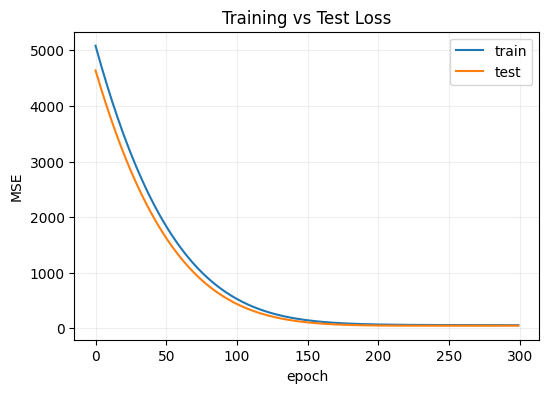

In [36]:
# Baseline: regression model

train_loader, test_loader = make_loaders(
    X_train_np,
    y_train.to_numpy(),
    X_test_np,
    y_test.to_numpy(),
    batch_size=32,
)

model = StudentSuccessLinear(input_dim=X_train_np.shape[1])
train_losses, test_losses = train_regression(model, train_loader, test_loader, epochs=300, lr=1e-2)

# Plot loss curves
plt.figure(figsize=(6, 4))
plt.plot(train_losses, label="train")
plt.plot(test_losses, label="test")
plt.xlabel("epoch")
plt.ylabel("MSE")
plt.title("Training vs Test Loss")
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()


In [37]:
# Evaluate regression (MSE, R^2)

model.eval()
with torch.no_grad():
    X_test_t = torch.tensor(X_test_np, dtype=torch.float32).to(DEVICE)
    preds = model(X_test_t).cpu().numpy().reshape(-1)

mse = mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)
print("Test MSE:", round(mse, 3))
print("Test R2:", round(r2, 3))


Test MSE: 47.335
Test R2: 0.466


## 7) Your turn: improve the model

Minimum requirements:
- Add **≥2 engineered features**
- Justify features with EDA
- Train either:
  - regression, or
  - classification (you must pick a label definition + threshold)

Stretch goals:
- try L2 regularization (`weight_decay`)
- compare regression vs classification framing
- interpret weights: which features help/hurt predicted success?

---

### Optional: classification scaffold


### Improving with L2 regularization

changing to `epochs=100` and `lr=2e-2` to see if MSE or $R^2$ improves

Epoch   50 | train MSE 50.641 | test MSE 56.292
Epoch  100 | train MSE 50.086 | test MSE 58.901


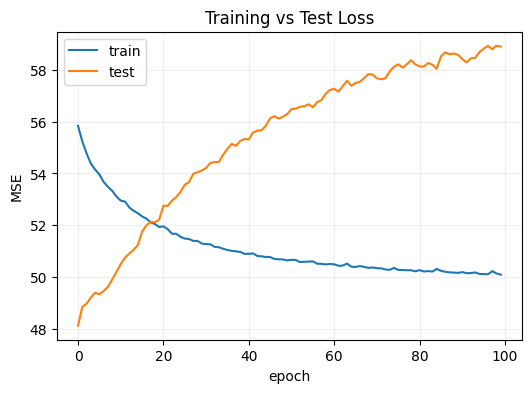

In [38]:
train_losses_l2, test_losses_l2 = train_regression_l2(model, train_loader, test_loader, epochs=100, lr=2e-2, weight_decay=1e-3)

# Plot loss curves
plt.figure(figsize=(6, 4))
plt.plot(train_losses_l2, label="train")
plt.plot(test_losses_l2, label="test")
plt.xlabel("epoch")
plt.ylabel("MSE")
plt.title("Training vs Test Loss")
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()

In [39]:
# Evaluate regression (MSE, R^2)

model.eval()
with torch.no_grad():
    X_test_t = torch.tensor(X_test_np, dtype=torch.float32).to(DEVICE)
    preds = model(X_test_t).cpu().numpy().reshape(-1)

mse = mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)
print("Test MSE:", round(mse, 3))
print("Test R2:", round(r2, 3))

Test MSE: 58.901
Test R2: 0.335


### Interpreting Weights

Feature Importance Table:
                                              feature    weight
11                                  cat__pillar_Other  9.351078
19                            cat__prereq_ct_grade_B-  8.994500
18                            cat__prereq_ct_grade_B+  8.250151
36    cat__diag_pca_answer_Calculating the derivative  7.562636
37  cat__diag_pca_answer_Finding eigenvalues and e...  7.509871
22                    cat__used_pytorch_tensorflow_No  7.339406
34  cat__diag_pvalue_answer_Statistically signific...  7.239696
6                                     cat__pillar_ASD  7.235562
42                     cat__laptop_or_cloud_ready_Yes  7.214535
38          cat__diag_pca_answer_Integration by parts  7.208334
12                           cat__current_term_Term 6  7.106205
40             cat__team_formed_for_final_project_Yes  7.027235
28                      cat__diag_python_mod_answer_1  6.943418
27                   cat__diag_python_mod_answer_0.66  6.809682
7             

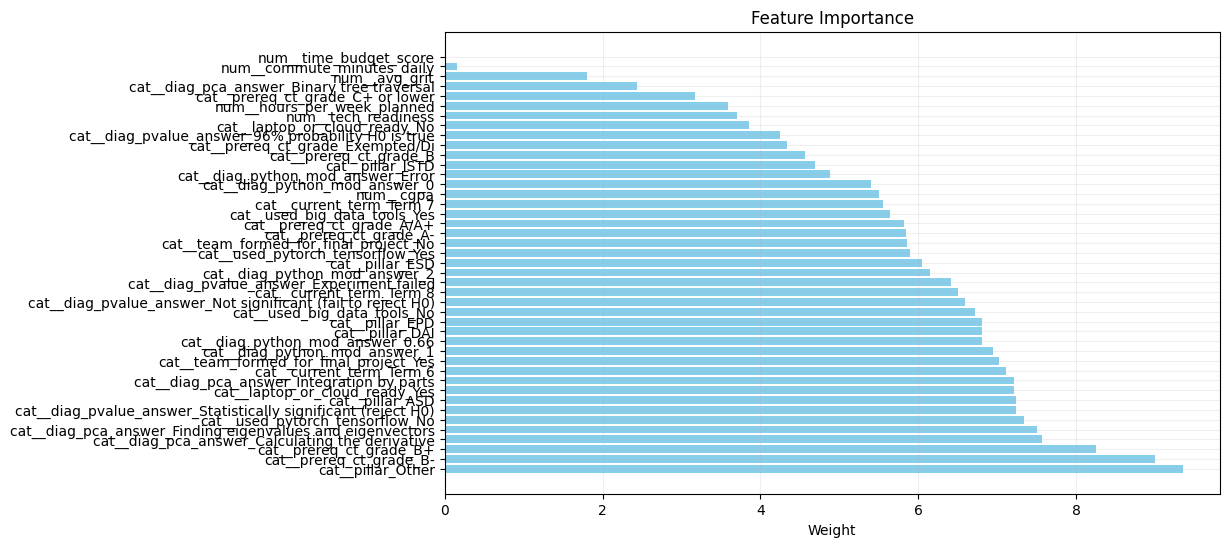

In [40]:
# Get weights from the trained model (shape: 1 x n_features)
weights = model.linear.weight.detach().cpu().numpy().flatten()
bias = model.linear.bias.detach().cpu().item()

# Get feature names from the preprocessor (same order as columns in X_train_np)
feature_names = preprocess.get_feature_names_out()

# Create a small table for interpretation
weight_df = pd.DataFrame({
    "feature": feature_names,
    "weight": weights,
}).sort_values("weight", key=abs, ascending=False)

print("Feature Importance Table:")
print(weight_df)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(weight_df["feature"], weight_df["weight"], color="skyblue")
plt.xlabel("Weight")
plt.title("Feature Importance")
plt.grid(True, alpha=0.2)
plt.show()


As seen from the graph above, the top 3 features are as followed: 

1. Pillar (Other)
2. Pre-requisite CTD Grade (B-)
3. Laptop or Cloud Ready (Yes)

Having a working setup and having experience with cloud means their readiness is much higher which is plausibly linked to better course outcomes. CTD is a pre-req to CDS which means the model is picking up that having a grade of B- relative to whatever referenced grade is associated to better predicted performance. Lastly, Pillar is highly associated as there may be a high number of students who might not want to disclose their pillar, the model is capturing on average these group of people have a higher predicted success. 

In contrast, there are 2 features which are hurts the predicted success and are as followed: 

1. Commute Minutes Daily
2. Time Budget Score

This showcases that the time taken to commute to campus daily does not affect the predicted success of this course, which infers that the model believes that this feature does not affect the targeted outcome greatly. Since time budget score is an engineered feature from time take to commute, the model is showcasing similar results to this feature as well. 

In [41]:
# # OPTIONAL (Classification)
# # Define a binary label. Example: distinction if score >= 85.

# from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# DISTINCTION_THRESHOLD = 80  # TODO: try different thresholds

# y_bin = (df["final_course_score"] >= DISTINCTION_THRESHOLD).astype(int)
# print("Positive rate (label=1):", float(y_bin.mean()))


# X_train, X_test, y_train, y_test = train_test_split(
#     df[feature_cols], y_bin, test_size=0.2, random_state=SEED, stratify=y_bin
# )

# X_train_np = preprocess.fit_transform(X_train)
# X_test_np = preprocess.transform(X_test)

# train_loader, test_loader = make_loaders(
#     X_train_np,
#     y_train.to_numpy(),
#     X_test_np,
#     y_test.to_numpy(),
#     batch_size=32,
# )

# model = StudentSuccessLinear(input_dim=X_train_np.shape[1]).to(DEVICE)
# criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.Adam(model.parameters(), lr=1e-2)

# EPOCHS = 300
# for epoch in range(1, EPOCHS + 1):
#     model.train()
#     for xb, yb in train_loader:
#         xb = xb.to(DEVICE)
#         yb = yb.to(DEVICE)

#         logits = model(xb)
#         loss = criterion(logits, yb)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#     if epoch % 50 == 0:
#         print("epoch", epoch, "loss", float(loss))

# # Evaluate
# model.eval()
# with torch.no_grad():
#     X_test_t = torch.tensor(X_test_np, dtype=torch.float32).to(DEVICE)
#     logits = model(X_test_t).cpu().numpy().reshape(-1)

# probs = 1 / (1 + np.exp(-logits))
# THRESHOLD = 0.5
# preds = (probs >= THRESHOLD).astype(int)

# cm = confusion_matrix(y_test, preds)
# print("Confusion matrix:
# ", cm)
# print("Precision:", precision_score(y_test, preds))
# print("Recall:", recall_score(y_test, preds))
# print("F1:", f1_score(y_test, preds))

# # TODO: Tune THRESHOLD for higher Recall (why might that matter for at-risk alerts?)


## 8) PCA: do students cluster by academic pillar?

Use PCA on the **preprocessed design matrix** and visualize the first 2 components.

Prompt:
- Do you see clusters? If not, why might that be?
- What does PCA *not* tell you?


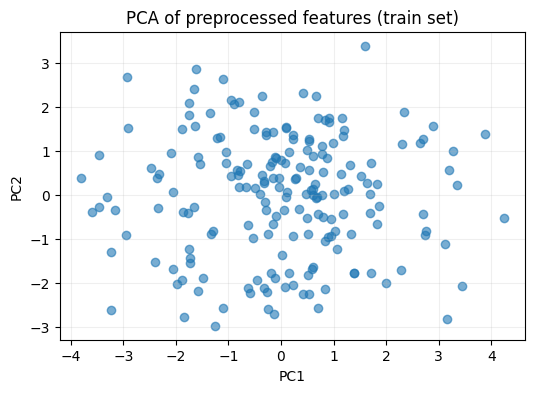

Explained variance ratio: [0.21358162 0.16276543]


In [42]:
from sklearn.decomposition import PCA

# Fit PCA on the TRAIN matrix (no leakage)
pca = PCA(n_components=2, random_state=SEED)
Z = pca.fit_transform(X_train_np)

plt.figure(figsize=(6, 4))
plt.scatter(Z[:, 0], Z[:, 1], alpha=0.6)
plt.title("PCA of preprocessed features (train set)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True, alpha=0.2)
plt.show()

print("Explained variance ratio:", pca.explained_variance_ratio_)


**Do we see clusters? If not, why might that be?**

As seen from the graph above, the plot does not show any distinct clusters. The data points are well-separated with no obvious groups showcasing that there isn't any significant cluster. 

Pillar may not separate students much in this space. Academic pillar is one possible grouping, but the first 2 PCs are built to capture maximum variance, not separation by pillar, so pillar differences might be weak in PC1-PC2 or spread across other components. 

Preprocessing and mixing of feature could be a potential issue as well, numeric and one-hot features are combined and scaled. The main variance may reflect things like CGPA, grit or technical readiness rather than pillar, so student from different can overlap in PC1-PC2. 

There are only 2 components in PCA. Any structure that exists in more dimensions (PC3, PC4) is not visible here, so we cannot rule out clusters in full space. 

With limited data and possibly similar score distributions across pillars, the clusters may be too weak or overlapping to see in 2D. 

**What does PCA not tell you?**

PCA does not tell us what the axes mean in real term. PC1 and PC2 are linear combinations of all preprocessed features. We do not know from the plot alone which original variable (pillar, CGPA, grit, etc.) drive each component unless we look at loadings or correlations. 

Additionally, PCA is dimensionality reduction, not clustering. The plot as seen above does not tell us the true number of groups or if there are any clusters in higher dimensions. 

Also, PCA finds directions of maximum variance, it does not imply that any variable causes another or causes success and the points are uncoloured by pillar (or any label) in the plot, so we cannot see which point is which group, we are only able to see the overall spread.

Lastly, high variance in a PC does not gurantee that it helps predict `final_course_score`, that would require a model (such as the regression model above) or other analysis. 

## 9) The “At‑Risk Intervention Alert” (agentic add‑on)

In educational data mining, prediction is only useful if it leads to **action**.

Design a function that:
- identifies at-risk students
- outputs a **pedagogical recommendation** (specific + actionable)

Examples of recommendations:
- “Review Python basics: `2 % 3`, loops, lists”
- “Attend Week 1–2 recap clinic”
- “Form a project team early + schedule 2h/week study block”

⚠️ Ethics: the alert should be supportive, not punitive.


In [43]:
def recommend_intervention(row, predicted_score=None, threshold=70):
    '''Return (risk_level, recommendation).

    TODO: tune rules based on your EDA + model.
    '''
    # Guard: row must be a dict (e.g. from df.iloc[i].to_dict())
    if not isinstance(row, dict):
        return "medium", "Invalid row; pass a student row as dict (e.g. df.iloc[0].to_dict())."

    # Not at-risk: encourage and offer stretch tasks
    if predicted_score is not None and predicted_score >= threshold:
        return "low", "You're on track! Keep up the good work; consider helping peers or taking stretch tasks."

    # At risk: build a specific, supportive recommendation from survey context
    reasons = []

    # Python diagnostic (2 % 3 = 2)
    python_ans = row.get("diag_python_mod_answer")
    if python_ans is not None and str(python_ans).strip() != "2":
        reasons.append(("python", "Review Python basics: `2 % 3`, loops, lists. The Week 1-2 recap clinic and office hours is there to support you!"))

    # Stats/p-value diagnostic
    pvalue_ans = row.get("diag_pvalue_answer")
    pvalue_correct = "Statistically significant (reject H0)"
    if pvalue_ans is not None and str(pvalue_ans).strip() != pvalue_correct:
        reasons.append(("stats", "A quick refresher on hypothesis testing (p-value, alpha, etc.) can help. Attend the recap clinic or drop by during office hours."))

    # PCA / linear algebra diagnostic 
    pca_ans = row.get("diag_pca_answer")
    pca_correct = "Finding eigenvalues and eigenvectors"
    if pca_ans is not None and str(pca_ans).strip() != pca_correct:
        reasons.append(("pca", "Brushing up on PCA and linear algebra (e.g. eigenvalues/eigenvectors) will help. We have material and office hours to support you."))

    # No project team yet 
    team = row.get("team_formed_for_final_project")
    if team is not None and str(team).strip().lower() == "no":
        reasons.append(("team", "Form a project team early and block 2h/week for the project."))

    # Limited planned study time
    hours = row.get("hours_per_week_planned")
    if hours is not None and not (isinstance(hours, str) and hours.strip() == ""):
        try: 
            h = float(hours)
            if h < 5:
                reasons.append(("study", "Consider blocking 6-8 hours/week for this course on your calendar. Small, regular blocks often work better than long cram sessions."))
        except (TypeError, ValueError):
            pass

    # Lower GPA / foundations
    cgpa = row.get("cgpa")
    if cgpa is not None and not (isinstance(cgpa, str) and cgpa.strip() == ""):
        try:
            grade = float(cgpa)
            if grade < 3.5:
                reasons.append(("foundations", "A short consult with a TA can help you focus on the most important foundations and a weekly practice plan that works for you."))
        except (TypeError, ValueError):
            pass

    # Compute risk level and pick recommendation
    if len(reasons) >= 2:
        risk_level = "high"
    elif len(reasons) == 1:
        risk_level = "medium"
    else:
        risk_level = "medium"

    # Prefer the first reason that has a recommendation; keep message supportive
    if reasons: 
        _, recommendation = reasons[0]
        return risk_level, recommendation
 
    # Fallback: generic supportive message
    return "medium", "Be sure to block off time for this course and focus on the foundations. We have resources to support you!"
        

    # # Example rule-based scaffold
    # if predicted_score is not None and predicted_score < threshold:
    #     # Customize these rules
    #     if row.get("hours_per_week_planned") is not None and row.get("hours_per_week_planned") < 5:
    #         return "high", "Increase weekly study plan to 6–8h; block it on your calendar."
    #     if row.get("cgpa") is not None and row.get("cgpa") < 3.5:
    #         return "high", "Book a consult with TA; focus on foundations + weekly practice."
    #     return "medium", "Do the Week 1–2 refresher worksheet + attend office hours."

    # return "low", "Keep up the good work; consider helping peers or taking stretch tasks."


# Demo on one row (replace `predicted_score` with your model output)
# To test this cell alone: Kernel -> Restart, then run only Setup (0), Load data (1), and Preprocessing (5) so df exists, then run this cell.
try:
    example = df.iloc[0].to_dict()
except NameError:
    example = {"diag_python_mod_answer": "0", "hours_per_week_planned": 3}
    print("Note: df not loaded; using minimal example. Run data-loading cells first for real data.")
result = recommend_intervention(example, predicted_score=65)
print("Risk level:", result[0])
print("Recommendation:", result[1])


Risk level: medium
Recommendation: Review Python basics: `2 % 3`, loops, lists. The Week 1-2 recap clinic and office hours is there to support you!


## Submission checklist

Your notebook should:
- run end-to-end without errors
- include clear plots + short written interpretation
- include feature engineering + justification
- include a PyTorch `nn.Linear` model with training loop
- include evaluation metrics + a short discussion of limitations
- include the at-risk intervention function + ethical reflection

---

### Reflection prompts (write 3–6 sentences)
- What would make this model *unsafe* to deploy in real life?
- Which student groups might be disadvantaged by these features?
- What additional data would you want, and why?
